In [4]:
# Initial Setup:
# Import all the libraries we need

import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random
import os

from BSE import market_session

# The next are helper functions that you will use later, if they don't make 
# much sense now, don't worry too much about it they will become clearer later:

# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_tape.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot_trades(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_tape.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def plot_sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_tape.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black')   

# plot offset function
def plot_offset_fn(offset_fn, total_time_seconds):   
    x = list(range(total_time_seconds))
    offsets = []
    for i in range(total_time_seconds):
        offsets.append(offset_fn(i))
    plt.plot(x, offsets, 'x', color='black')  

In [5]:
buyers_spec = [('ZIC', 10)]
sellers_spec = [('ZIC', 10)]
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

In [6]:
sup_range = (50, 150)
dem_range = (50, 150)

In [7]:
start_time = 0
end_time = 600
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

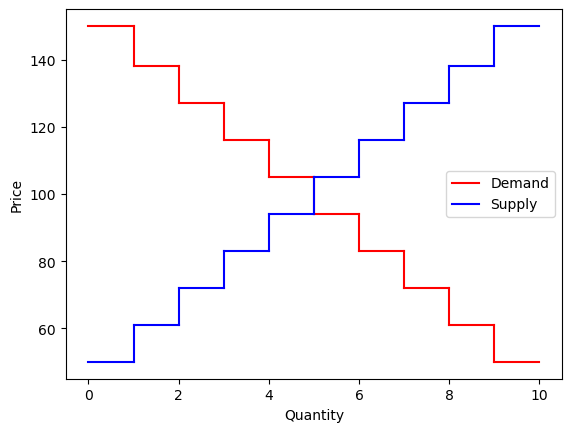

In [8]:
plot_sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

In [9]:
order_sched = {'sup': supply_schedule , 'dem': demand_schedule, 'interval': 60, 'timemode': 'periodic'}

In [10]:
trial_id = 'test_1'
tdump = open('test_1_avg_balance.csv','w')
dump_all = False
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

In [9]:
trial_id = 'test_1'
tdump = open('test_1_avg_balance2.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

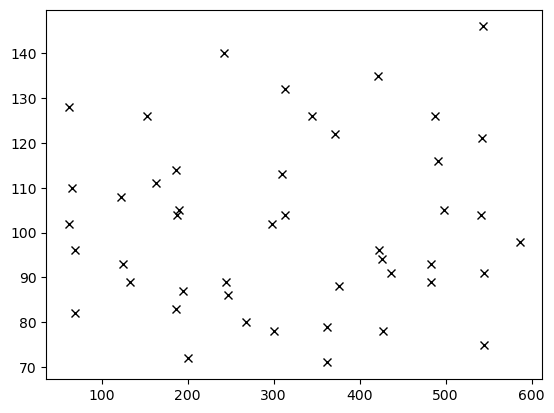

In [11]:
plot_trades('test_1')

In [58]:
def schedule_offsetfn(t):
        t /= 100
        pi2 = math.pi * 2
        c = math.pi * 3000
        wavelength = t / c
        gradient = 100 * t / (c / pi2)
        amplitude = 100 * t / (c / pi2)
        offset = gradient + amplitude * math.sin(wavelength * t)
        return int(round(offset, 0))

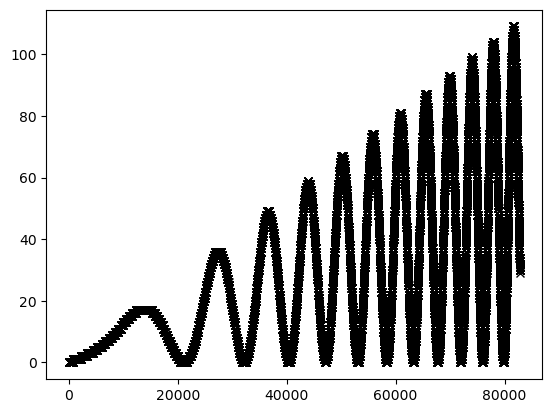

In [59]:
plot_offset_fn(schedule_offsetfn, 82800)

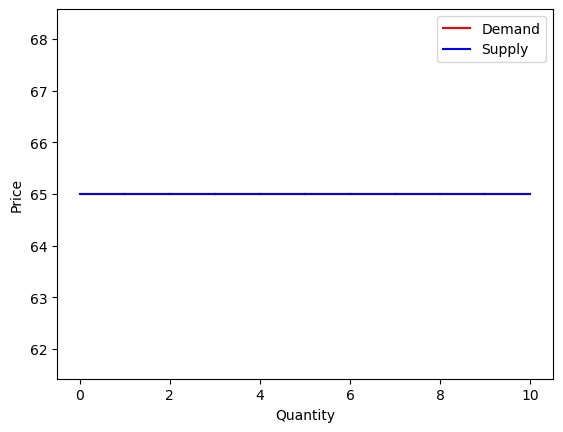

B00: PRDE active_strat=[0]:
[0]: s=-0.069656, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.773845, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.086558, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.752563, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.990031, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.246700, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.577028, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.890447, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.227037, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.690937, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.103513, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.697771, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.032472, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.521463, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.519413, start=0.000000, $=0.000000, pps=0.0000

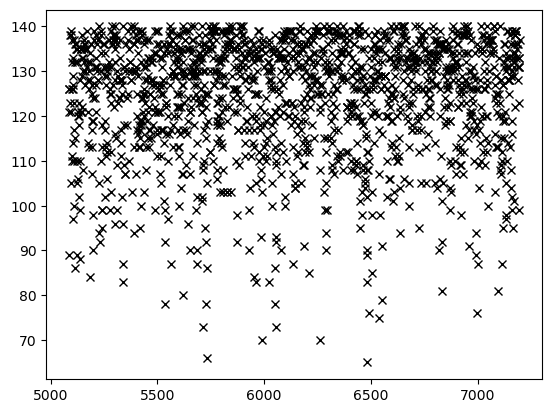

In [97]:
n_days = 0.1 # 1000 days is good, but 3*365=1095, so may as well go for three years.
start_time = 0.0
end_time = 60.0 * 60.0 * 2
duration = end_time - start_time


# First, configure the trader specifications
sellers_spec = [('PRDE', 10, {'k': 4, 's_min': -1.0, 's_max': +1.0})]
buyers_spec = [('PRDE', 10, {'k': 4, 's_min': -1.0, 's_max': +1.0})]
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

range1 = (65, 140)
range2 = (200, 270)

supply_schedule = [ {'from':start_time, 'to':duration/3, 'ranges':[range1], 'stepmode':'fixed'},
                    {'from':duration/3, 'to':2*duration/3, 'ranges':[range2], 'stepmode':'fixed'},
                    {'from':2*duration/3, 'to':end_time, 'ranges':[range1], 'stepmode':'fixed'}
                  ]
demand_schedule = supply_schedule
range1 = (65, 65)
range2 = (140,140)

supply_schedule = [{'from':start_time, 'to':end_time, 'ranges':[range1], 'stepmode': 'fixed'}]
demand_schedule = [{'from':start_time, 'to':end_time, 'ranges':[range2], 'stepmode': 'fixed'}]

# start_time = 0
# mid_time = 1000
# end_time = 3000
# supply_schedule = [{'from': start_time, 'to': mid_time, 'ranges': [range1], 'stepmode': 'fixed'},
#                    {'from': mid_time, 'to': mid_time*2, 'ranges': [range2], 'stepmode': 'fixed'}, 
#                    {'from': mid_time*2, 'to': end_time, 'ranges': [range1], 'stepmode': 'fixed'}]
# demand_schedule = supply_schedule

plot_sup_dem(10, [range1, range2, range1], 10, [range1, range2, range1], 'fixed')

order_interval = 5
order_sched = {'sup': supply_schedule , 'dem': demand_schedule, 'interval': order_interval, 'timemode': 'drip-jitter'}

n_trials = 1
trial = 1

while trial < (n_trials + 1):
    trial_id = 'bse_d%03d_i%02d_%04d' % (n_days, order_interval, trial)
    #completeName = os.path.join('../trial_data', fileName)
    tdump = open(f'{trial_id}_avg_balance.csv','w')
    dump_all = True
    verbose = True

    # Now, run the market session
    market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

    tdump.close()

    # Finally, plot the trades that executed during the market session
    plot_trades(trial_id)
    
    trial += 1

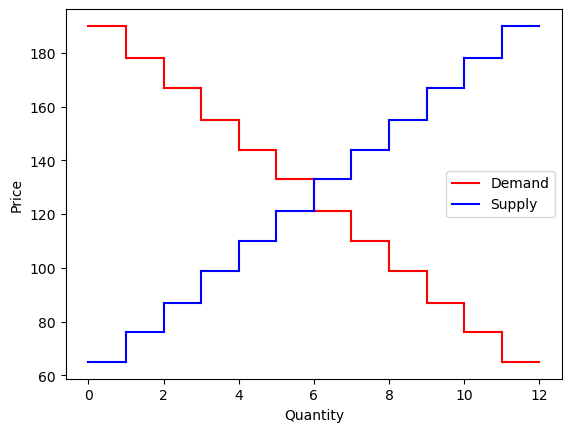

In [110]:
sup_range = (65, 190)
dem_range = (65, 190)
plot_sup_dem(12, [sup_range], 12, [sup_range], 'fixed')

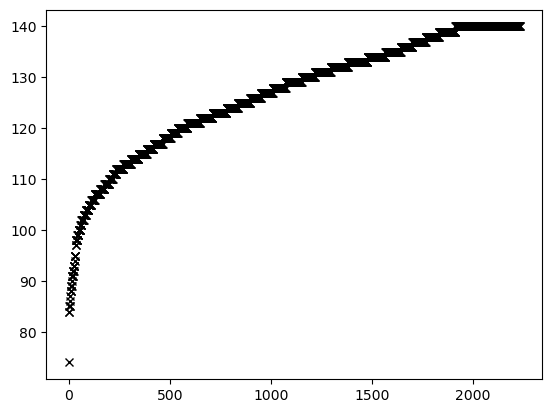

In [22]:
in_order_plot('bse_d001_i05_0001')

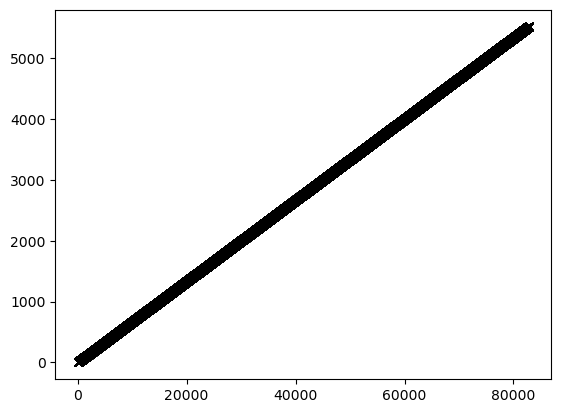

In [35]:
plot_offset_fn(schedule_offsetfn, 82800)

In [62]:
range1 = (65, 140, schedule_offsetfn)
range2 = (200, 270, schedule_offsetfn)

    
supply_schedule = [ {'from':start_time, 'to':duration/3, 'ranges':[range1], 'stepmode':'fixed'},
                    {'from':duration/3, 'to':2*duration/3, 'ranges':[range2], 'stepmode':'fixed'},
                    {'from':2*duration/3, 'to':end_time, 'ranges':[range1], 'stepmode':'fixed'}
                  ]

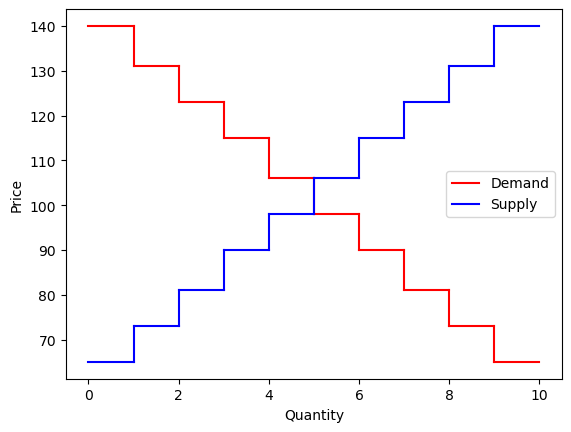

In [68]:
plot_sup_dem(10, [range1], 10, [range1], 'fixed')

In [61]:
round(0.20000002, 1)

0.2

In [112]:
import scipy as sp
from scipy import stats
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import pandas as pd

In [ ]:
df = pd.read_csv('all_results_k4_F1.8.csv') 

In [ ]:
print(df.mean(axis=0))
print(df.std())